# Multi Stage Prediction 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:
# Load Data

daily_data = pd.read_csv("merged_data_granualityBased/daily_merged_data.csv")
monthly_data = pd.read_csv("merged_data_granualityBased/merged_monthyl_data.csv")
yearly_data = pd.read_csv("merged_data_granualityBased/merged_Yearly_data.csv")


In [3]:
# Convert datetime columns
daily_data["date"] = pd.to_datetime(daily_data["date"])

daily_data.set_index("date", inplace=True)

In [4]:
# Ensure numerical columns are correctly formatted
yearly_data["Population"] = yearly_data["Population"].str.replace(',', '').astype(float)

In [5]:
# Feature Engineering Function
def feature_importance_rfa(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances.sort_values(ascending=False, inplace=True)
    
    # Print feature importances
    print("Feature Importances (Descending Order):")
    print(feature_importances)
    
    return feature_importances

## Stage 1: Yearly Forecasting

In [6]:
# One-Hot Encode PriceComponents
yearly_data = pd.get_dummies(yearly_data, columns=["PriceComponents"], drop_first=True)

In [7]:
# Ensure all rows are printed
pd.set_option('display.max_rows', None)

In [8]:
# Select Features and Target
yearly_features = yearly_data.drop(columns=["loadConsumption"])
yearly_target = "loadConsumption"
X_yearly = yearly_features
y_yearly = yearly_data[yearly_target]

In [9]:
# Compute feature importance
yearly_feature_importance = feature_importance_rfa(X_yearly, y_yearly)

# Select the top 5 features
selected_yearly_features = yearly_feature_importance.index[:5]
X_yearly = X_yearly[selected_yearly_features]

Feature Importances (Descending Order):
OffshoreWindEnergy (MWh)                                    1.077784e-01
TotalSolarEnergy (MWh)                                      8.411776e-02
Hydropower (MWh)                                            7.962589e-02
Total Including Non-Renewable (MWh)                         7.778631e-02
GeothermalHeat (MWh)                                        6.020471e-02
OnshoreWindEnergy (MWh)                                     5.963622e-02
Year                                                        5.633088e-02
AmbientAirHeat (MWh)                                        5.388781e-02
TotalBiomass (MWh)                                          5.142877e-02
Totaal windenergie (MWh)                                    4.593649e-02
TotalRes(excl.Stat.Transfer) (MWh)                          4.479325e-02
TotalRes(incl.Stat.Transfer) (MWh)                          3.891245e-02
SolarPower (MWh)                                            3.615954e-02
TotalGeothe

In [10]:
# Split Data
X_train_yearly, X_test_yearly, y_train_yearly, y_test_yearly = train_test_split(
    X_yearly, y_yearly, test_size=0.2, random_state=42
)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_yearly)
X_test_scaled = scaler.transform(X_test_yearly)

In [11]:
# Train Model
model_yearly = RandomForestRegressor(n_estimators=100, random_state=42)
model_yearly.fit(X_train_scaled, y_train_yearly)
y_pred_yearly = model_yearly.predict(X_test_scaled)

In [12]:
# Store yearly predictions in monthly dataset
monthly_data["Predicted_Yearly_Load"] = np.repeat(
    model_yearly.predict(scaler.transform(X_yearly)),
    len(monthly_data) // len(yearly_data)
)[:len(monthly_data)]

In [13]:
# Evaluate Model
print("Yearly Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_yearly, y_pred_yearly)}, "
      f"MSE: {mean_squared_error(y_test_yearly, y_pred_yearly)}, "
      f"R^2: {r2_score(y_test_yearly, y_pred_yearly)}, "
      f"MAPE: {np.mean(np.abs((y_test_yearly - y_pred_yearly) / y_test_yearly)) * 100}")

Yearly Model Performance:
MAE: 100407.7614599973, MSE: 13281873766.508518, R^2: 0.9991437378489579, MAPE: 0.08959670293005885


## Stage 2: Monthly Forecasting

In [14]:
monthly_data.isna().sum()

Year                                                      0
Month                                                     0
Gross production (MWh)                                    0
Net production/Net production, total (MWh)                0
Net production/Nuclear energy (MWh)                       3
Net production/Fuels/Fuels, total (MWh)                   0
Net production/Fuels/Coal (MWh)                           0
Net production/Fuels/Petroleum products (MWh)             0
Net production/Fuels/Natural gas (MWh)                    0
Net production/Fuels/Biomass (MWh)                        0
Net production/Fuels/Other fuels (non-renewable) (MWh)    0
Net production/Hydro power (MWh)                          0
Net production/Wind energy/Wind energy, total (MWh)       0
Net production/Wind energy/Wind energy on shore (MWh)     0
Net production/Wind energy/Wind energy off shore (MWh)    0
Net production/Solar photovoltaic (MWh)                   0
Net production/Other sources (MWh)      

In [15]:
monthly_data.fillna(method="ffill", inplace=True)

C:\Users\mahmo\AppData\Local\Temp\ipykernel_19180\1658306591.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data.fillna(method="ffill", inplace=True)


In [16]:
## Stage 2: Monthly Breakdown
monthly_features = monthly_data.drop(columns=["loadConsumption"])
monthly_target = "loadConsumption"
X_monthly = monthly_features
y_monthly = monthly_data[monthly_target]

# Compute feature importance
monthly_feature_importance = feature_importance_rfa(X_monthly, y_monthly)
selected_monthly_features = list(monthly_feature_importance.index[:5]) + ["Predicted_Yearly_Load"]
X_monthly = X_monthly[selected_monthly_features]

# Train Monthly Model
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly, test_size=0.2, random_state=42)
X_train_scaled_monthly = scaler.fit_transform(X_train_monthly)
X_test_scaled_monthly = scaler.transform(X_test_monthly)

model_monthly = RandomForestRegressor(n_estimators=100, random_state=42)
model_monthly.fit(X_train_scaled_monthly, y_train_monthly)
y_pred_monthly = model_monthly.predict(X_test_scaled_monthly)

# Store monthly predictions in daily dataset
# Expand monthly predictions to match daily data size
num_days_per_month = len(daily_data) // len(monthly_data)
predicted_monthly_load = np.repeat(model_monthly.predict(scaler.transform(X_monthly)), num_days_per_month)

# Handle potential size mismatch
if len(predicted_monthly_load) < len(daily_data):
    predicted_monthly_load = np.append(predicted_monthly_load, predicted_monthly_load[-1] * np.ones(len(daily_data) - len(predicted_monthly_load)))

daily_data["Predicted_Monthly_Load"] = predicted_monthly_load[:len(daily_data)]


# Evaluate
print("Monthly Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_monthly, y_pred_monthly)}, MSE: {mean_squared_error(y_test_monthly, y_pred_monthly)}, R^2: {r2_score(y_test_monthly, y_pred_monthly)}, MAPE: {np.mean(np.abs((y_test_monthly - y_pred_monthly) / y_test_monthly)) * 100}")






Feature Importances (Descending Order):
Net consumption (calculated) (MWh)                        0.451888
Net production/Solar photovoltaic (MWh)                   0.388441
Net production/Fuels/Fuels, total (MWh)                   0.060637
Net production/Nuclear energy (MWh)                       0.016948
Predicted_Yearly_Load                                     0.015595
Net production/Fuels/Biomass (MWh)                        0.007527
Net production/Fuels/Coal (MWh)                           0.005379
Imports/Imports, total (MWh)                              0.004709
Net production/Fuels/Petroleum products (MWh)             0.004632
Net production/Fuels/Natural gas (MWh)                    0.004390
Month                                                     0.004352
NAO                                                       0.004289
Gross production (MWh)                                    0.004254
Net production/Net production, total (MWh)                0.003461
Exports/Exports, total

In [17]:
daily_data = pd.get_dummies(daily_data, columns=["day_of_week"], drop_first=True)

## STage 3: Daily Forecasting

In [18]:
## Stage 3: Daily Forecasting
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Monthly_Load"]
X_daily = X_daily[selected_daily_features]

# Train Daily Model
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)
X_train_scaled_daily = scaler.fit_transform(X_train_daily)
X_test_scaled_daily = scaler.transform(X_test_daily)

model_daily = RandomForestRegressor(n_estimators=100, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)
y_pred_daily = model_daily.predict(X_test_scaled_daily)

# Evaluate
print("Daily Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_daily, y_pred_daily)}, MSE: {mean_squared_error(y_test_daily, y_pred_daily)}, R^2: {r2_score(y_test_daily, y_pred_daily)}, MAPE: {np.mean(np.abs((y_test_daily - y_pred_daily) / y_test_daily)) * 100}")

Feature Importances (Descending Order):
HourlyMaxTemperature      0.291339
day_of_week_Sunday        0.173419
WeekKey                   0.161345
day_of_week_Saturday      0.112673
Week                      0.086969
Predicted_Monthly_Load    0.052226
Year                      0.020209
Month                     0.017981
HourlyMinTemperature      0.015753
DailyMeanTemperature      0.011025
DailyPrecipitation        0.008425
DailyMeanWindspeed        0.007470
HDMaxMeanWindspeed        0.006690
HDMaxPrecipitation        0.005680
HDMaxTemperature          0.005511
MaxHourlyPrecipitation    0.005396
HDMinTemperature          0.004407
HDMinMeanWindspeed        0.004237
MaxHourlyMeanWindspeed    0.003323
MinHourlyMeanWindspeed    0.002957
day_of_week_Monday        0.001372
day_of_week_Thursday      0.000592
day_of_week_Wednesday     0.000518
day_of_week_Tuesday       0.000483
dtype: float64
Daily Model Performance:
MAE: 7699.46939756639, MSE: 137338858.86392844, R^2: 0.8554549827021314, MAPE: 2

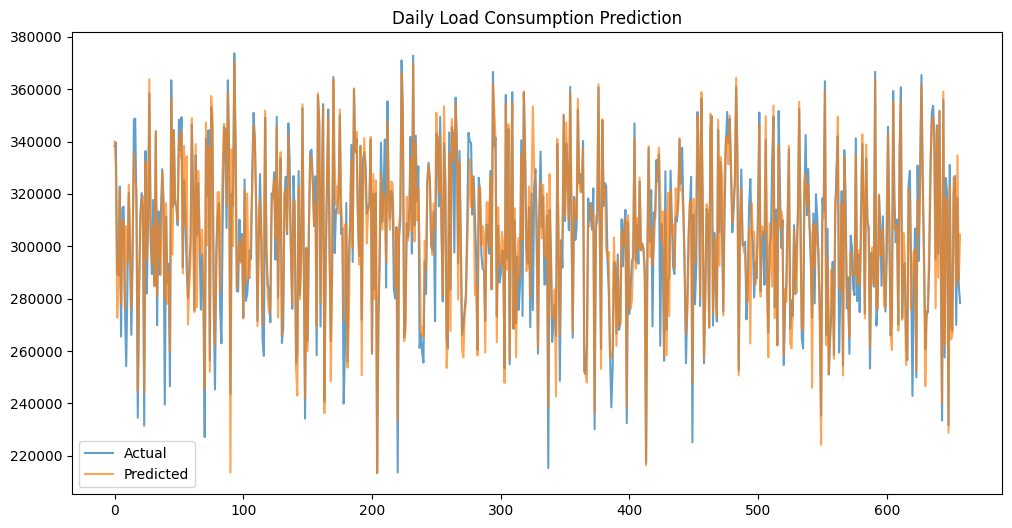

In [19]:
# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_daily.values, label="Actual", alpha=0.7)
plt.plot(y_pred_daily, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Daily Load Consumption Prediction")
plt.show()


## Prediction Horizon on ==f 180 days

In [20]:
## Stage 3: Future Daily Forecasting, prediction horizon of 180 days

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Monthly_Load"]
X_daily = X_daily[selected_daily_features]

# Define prediction horizon (180-365 days into the future)
prediction_horizon = 180  # Change to 180 if needed
X_train_daily = X_daily.iloc[:-prediction_horizon]
y_train_daily = y_daily.iloc[:-prediction_horizon]
X_future = X_daily.iloc[-prediction_horizon:]

# Train Daily Model
scaler = StandardScaler()
X_train_scaled_daily = scaler.fit_transform(X_train_daily)
X_future_scaled = scaler.transform(X_future)

model_daily = RandomForestRegressor(n_estimators=100, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)
y_future_pred = model_daily.predict(X_future_scaled)


Feature Importances (Descending Order):
HourlyMaxTemperature      0.327333
WeekKey                   0.202059
day_of_week_Sunday        0.173485
Week                      0.123072
day_of_week_Saturday      0.112785
Predicted_Monthly_Load    0.061267
dtype: float64


Future Daily Model Performance:
Predictions for the next 180 days generated.


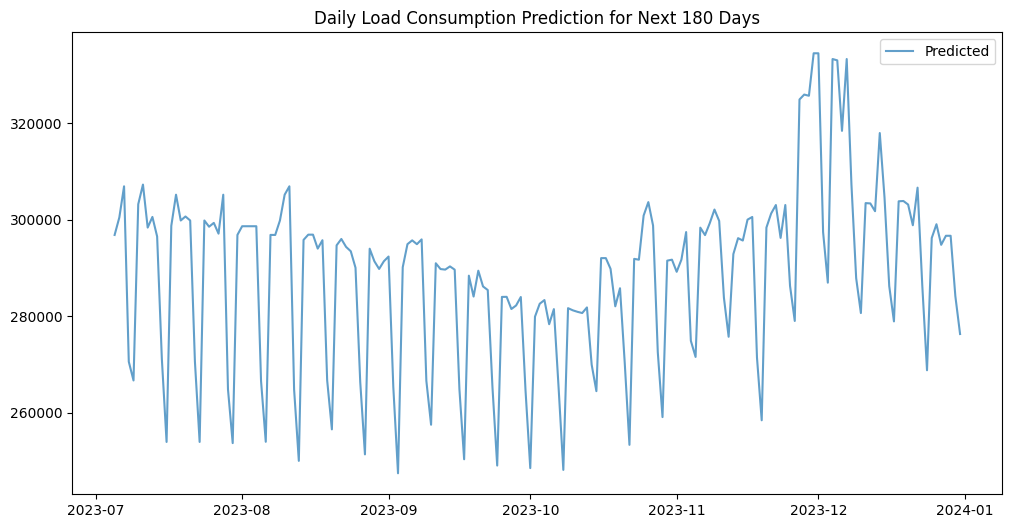

In [21]:
# Evaluate
print("Future Daily Model Performance:")
print(f"Predictions for the next {prediction_horizon} days generated.")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_daily.index[-prediction_horizon:], y_future_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title(f"Daily Load Consumption Prediction for Next {prediction_horizon} Days")
plt.show()


#### Testing withou monthly_prediction

In [22]:
## Stage 3: Daily Forecasting (no previous predictions)
# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5])

# Train Daily Model
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)
X_train_scaled_daily = scaler.fit_transform(X_train_daily)
X_test_scaled_daily = scaler.transform(X_test_daily)

model_daily = RandomForestRegressor(n_estimators=100, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)
y_pred_daily = model_daily.predict(X_test_scaled_daily)

# Evaluate
print("Daily Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_daily, y_pred_daily)}, MSE: {mean_squared_error(y_test_daily, y_pred_daily)}, R^2: {r2_score(y_test_daily, y_pred_daily)}, MAPE: {np.mean(np.abs((y_test_daily - y_pred_daily) / y_test_daily)) * 100}")

Feature Importances (Descending Order):
HourlyMaxTemperature      0.327346
WeekKey                   0.202133
day_of_week_Sunday        0.173485
Week                      0.122917
day_of_week_Saturday      0.112785
Predicted_Monthly_Load    0.061334
dtype: float64
Daily Model Performance:
MAE: 7706.686599357173, MSE: 137639701.73035207, R^2: 0.855138354635677, MAPE: 2.6376917300673033


Feature Importances (Descending Order):
HourlyMaxTemperature      0.291339
day_of_week_Sunday        0.173419
WeekKey                   0.161345
day_of_week_Saturday      0.112673
Week                      0.086969
Predicted_Monthly_Load    0.052226
Year                      0.020209
Month                     0.017981
HourlyMinTemperature      0.015753
DailyMeanTemperature      0.011025
DailyPrecipitation        0.008425
DailyMeanWindspeed        0.007470
HDMaxMeanWindspeed        0.006690
HDMaxPrecipitation        0.005680
HDMaxTemperature          0.005511
MaxHourlyPrecipitation    0.005396
HDMinTemperature          0.004407
HDMinMeanWindspeed        0.004237
MaxHourlyMeanWindspeed    0.003323
MinHourlyMeanWindspeed    0.002957
day_of_week_Monday        0.001372
day_of_week_Thursday      0.000592
day_of_week_Wednesday     0.000518
day_of_week_Tuesday       0.000483
dtype: float64
2019 Model Performance:
MAE: 15918.38882563601, MSE: 384567155.04042214, R^2: 0.5629308371185787, MAPE: 5

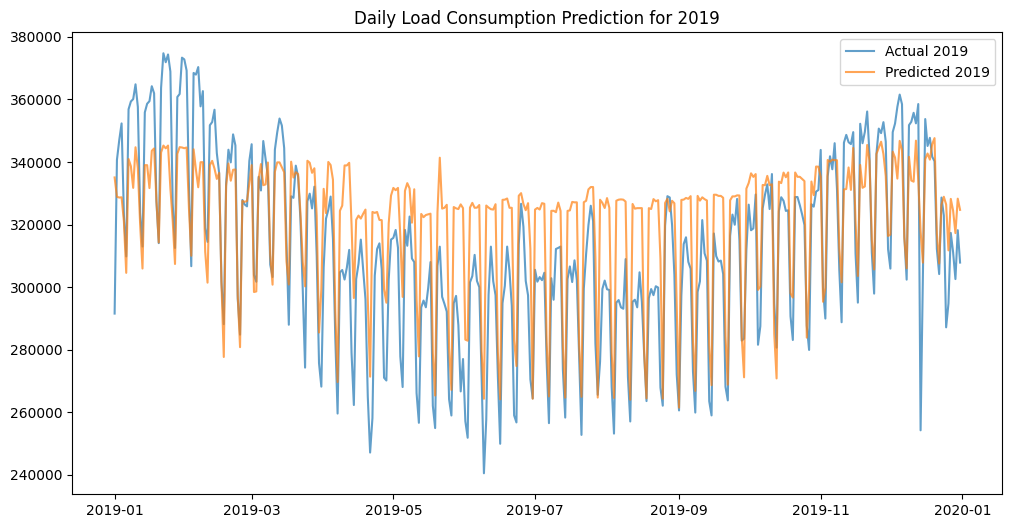

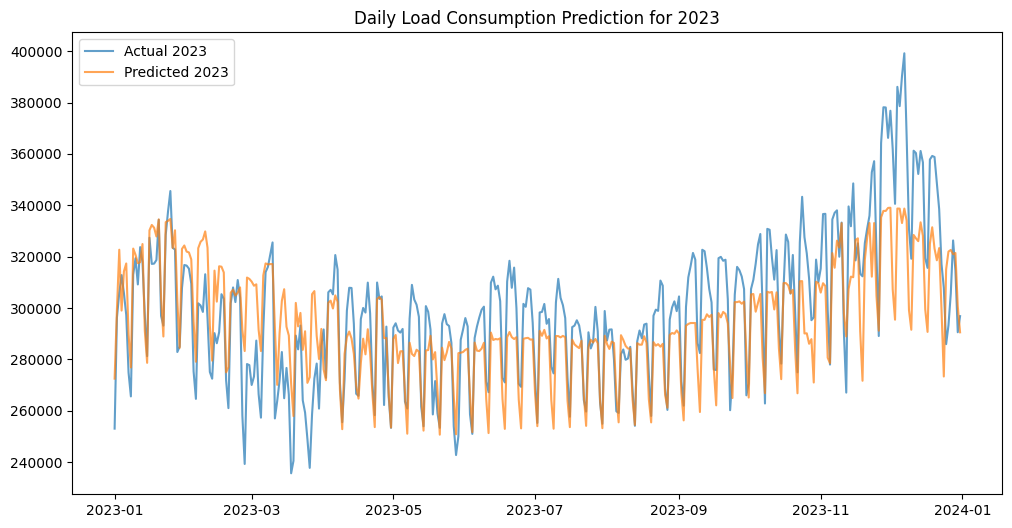

In [23]:
## Stage 3: Testing Performance on 2019 and 2023
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Monthly_Load"]
X_daily = X_daily[selected_daily_features]

# Define 2019 and 2023 data
X_train_2019 = X_daily.loc["2018-01-01":"2018-12-31"]
y_train_2019 = y_daily.loc["2018-01-01":"2018-12-31"]
X_test_2019 = X_daily.loc["2019-01-01":"2019-12-31"]
y_test_2019 = y_daily.loc["2019-01-01":"2019-12-31"]

X_train_2022 = X_daily.loc["2021-01-01":"2021-12-31"]
y_train_2022 = y_daily.loc["2021-01-01":"2021-12-31"]
X_test_2023 = X_daily.loc["2023-01-01":"2023-12-31"]
y_test_2023 = y_daily.loc["2023-01-01":"2023-12-31"]

# Train Model on 2018 and Predict 2019
scaler = StandardScaler()
X_train_scaled_2019 = scaler.fit_transform(X_train_2019)
X_test_scaled_2019 = scaler.transform(X_test_2019)

model_2019 = RandomForestRegressor(n_estimators=100, random_state=42)
model_2019.fit(X_train_scaled_2019, y_train_2019)
y_pred_2019 = model_2019.predict(X_test_scaled_2019)

# Train Model on 2021 and Predict 2023
X_train_scaled_2022 = scaler.fit_transform(X_train_2022)
X_test_scaled_2023 = scaler.transform(X_test_2023)

model_2023 = RandomForestRegressor(n_estimators=100, random_state=42)
model_2023.fit(X_train_scaled_2022, y_train_2022)
y_pred_2023 = model_2023.predict(X_test_scaled_2023)

# Evaluate
print("2019 Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_2019, y_pred_2019)}, MSE: {mean_squared_error(y_test_2019, y_pred_2019)}, R^2: {r2_score(y_test_2019, y_pred_2019)}, MAPE: {np.mean(np.abs((y_test_2019 - y_pred_2019) / y_test_2019)) * 100}")

print("2023 Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_2023, y_pred_2023)}, MSE: {mean_squared_error(y_test_2023, y_pred_2023)}, R^2: {r2_score(y_test_2023, y_pred_2023)}, MAPE: {np.mean(np.abs((y_test_2023 - y_pred_2023) / y_test_2023)) * 100}")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_2019.index, y_test_2019, label="Actual 2019", alpha=0.7)
plt.plot(y_test_2019.index, y_pred_2019, label="Predicted 2019", alpha=0.7)
plt.legend()
plt.title("Daily Load Consumption Prediction for 2019")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_2023.index, y_test_2023, label="Actual 2023", alpha=0.7)
plt.plot(y_test_2023.index, y_pred_2023, label="Predicted 2023", alpha=0.7)
plt.legend()
plt.title("Daily Load Consumption Prediction for 2023")
plt.show()


In [25]:
# Single-Stage Model: Train Directly on Full Data
X_train_single = X_daily.loc["2018-01-01":"2021-12-31"]
y_train_single = y_daily.loc["2018-01-01":"2021-12-31"]
X_test_single_2019 = X_daily.loc["2019-01-01":"2019-12-31"]
y_test_single_2019 = y_daily.loc["2019-01-01":"2019-12-31"]
X_test_single_2023 = X_daily.loc["2023-01-01":"2023-12-31"]
y_test_single_2023 = y_daily.loc["2023-01-01":"2023-12-31"]

scaler_single = StandardScaler()
X_train_scaled_single = scaler_single.fit_transform(X_train_single)
X_test_scaled_single_2019 = scaler_single.transform(X_test_single_2019)
X_test_scaled_single_2023 = scaler_single.transform(X_test_single_2023)

# Train Single-Stage Model (XGBoost for better results)
model_single = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5)
model_single.fit(X_train_scaled_single, y_train_single)
y_pred_single_2019 = model_single.predict(X_test_scaled_single_2019)
y_pred_single_2023 = model_single.predict(X_test_scaled_single_2023)

# Evaluate
print("2019 Single-Stage Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_single_2019, y_pred_single_2019)}, "
      f"MSE: {mean_squared_error(y_test_single_2019, y_pred_single_2019)}, "
      f"R^2: {r2_score(y_test_single_2019, y_pred_single_2019)}, "
      f"MAPE: {np.mean(np.abs((y_test_single_2019 - y_pred_single_2019) / y_test_single_2019)) * 100}")

print("2023 Single-Stage Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_single_2023, y_pred_single_2023)}, "
      f"MSE: {mean_squared_error(y_test_single_2023, y_pred_single_2023)}, "
      f"R^2: {r2_score(y_test_single_2023, y_pred_single_2023)}, "
      f"MAPE: {np.mean(np.abs((y_test_single_2023 - y_pred_single_2023) / y_test_single_2023)) * 100}")


2019 Single-Stage Model Performance:
MAE: 4316.224335616439, MSE: 39097222.42117571, R^2: 0.9555651332916981, MAPE: 1.4176510581183837
2023 Single-Stage Model Performance:
MAE: 22182.090229452053, MSE: 635586960.2709302, R^2: 0.2163620474885386, MAPE: 7.405669152719367


plt.figure(figsize=(12,6))
plt.plot(y_test_single_2019.index, y_test_single_2019, label="Actual 2019", alpha=0.7)
plt.plot(y_test_single_2019.index, y_pred_single_2019, label="Single-Stage 2019", alpha=0.7)
plt.plot(y_test_2019.index, y_pred_2019, label="Multi-Stage 2019", linestyle="dashed")
plt.legend()
plt.title("Comparison of Single-Stage vs Multi-Stage Prediction for 2019")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_single_2023.index, y_test_single_2023, label="Actual 2023", alpha=0.7)
plt.plot(y_test_single_2023.index, y_pred_single_2023, label="Single-Stage 2023", alpha=0.7)
plt.plot(y_test_2023.index, y_pred_2023, label="Multi-Stage 2023", linestyle="dashed")
plt.legend()
plt.title("Comparison of Single-Stage vs Multi-Stage Prediction for 2023")
plt.show()


In [27]:
daily_data.columns

Index(['loadConsumption', 'DailyPrecipitation', 'MaxHourlyPrecipitation',
       'HDMaxPrecipitation', 'DailyMeanTemperature', 'HourlyMinTemperature',
       'HDMinTemperature', 'HourlyMaxTemperature', 'HDMaxTemperature',
       'DailyMeanWindspeed', 'MaxHourlyMeanWindspeed', 'HDMaxMeanWindspeed',
       'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed', 'Month', 'Year', 'Week',
       'WeekKey', 'Predicted_Monthly_Load', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [28]:
### LSTM

Epoch 1/50
163/163 [==============================] - 22s 98ms/step - loss: 0.5135 - val_loss: 0.4620
Epoch 2/50
163/163 [==============================] - 15s 95ms/step - loss: 0.2625 - val_loss: 0.2882
Epoch 3/50
163/163 [==============================] - 16s 98ms/step - loss: 0.1763 - val_loss: 0.3681
Epoch 4/50
163/163 [==============================] - 15s 94ms/step - loss: 0.1435 - val_loss: 0.2483
Epoch 5/50
163/163 [==============================] - 16s 97ms/step - loss: 0.1287 - val_loss: 0.2625
Epoch 6/50
163/163 [==============================] - 14s 88ms/step - loss: 0.1237 - val_loss: 0.3353
Epoch 7/50
163/163 [==============================] - 16s 99ms/step - loss: 0.1175 - val_loss: 0.2018
Epoch 8/50
163/163 [==============================] - 13s 81ms/step - loss: 0.1117 - val_loss: 0.1922
Epoch 9/50
163/163 [==============================] - 11s 65ms/step - loss: 0.1057 - val_loss: 0.1835
Epoch 10/50
163/163 [==============================] - 11s 66ms/step - loss: 0.107

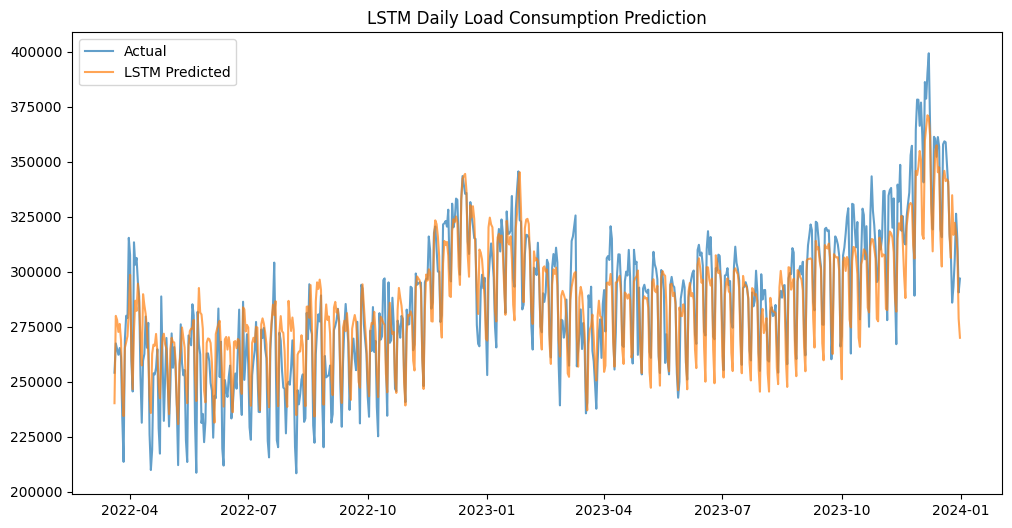

In [29]:
# Define LSTM Data Preparation Function
def prepare_lstm_data(data, target_column, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

# Select Features and Target
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"

# Scale features
scaler_features = StandardScaler()
daily_features_scaled = scaler_features.fit_transform(daily_features)

# Scale target separately
scaler_target = StandardScaler()
daily_target_scaled = scaler_target.fit_transform(daily_data[["loadConsumption"]])

# Combine features and target into a DataFrame
daily_scaled_df = pd.DataFrame(daily_features_scaled, index=daily_data.index, columns=daily_features.columns)
daily_scaled_df["loadConsumption"] = daily_target_scaled  # Add target back

# Prepare LSTM Data
lookback = 30  # Use past 30 days to predict next day
X_lstm, y_lstm = prepare_lstm_data(daily_scaled_df, "loadConsumption", lookback)

# Split Data into Train and Test
split_index = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# Define LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, X_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile Model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test_lstm))

# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Rescale Predictions
y_pred_lstm = scaler_target.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test_lstm = scaler_target.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluate Model
print("LSTM Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_lstm, y_pred_lstm)}, MSE: {mean_squared_error(y_test_lstm, y_pred_lstm)}, R^2: {r2_score(y_test_lstm, y_pred_lstm)}, MAPE: {np.mean(np.abs((y_test_lstm - y_pred_lstm) / y_test_lstm)) * 100}")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(daily_data.index[-len(y_test_lstm):], y_test_lstm, label="Actual", alpha=0.7)
plt.plot(daily_data.index[-len(y_test_lstm):], y_pred_lstm, label="LSTM Predicted", alpha=0.7)
plt.legend()
plt.title("LSTM Daily Load Consumption Prediction")
plt.show()


### Multi Stage ARIMA + LSTM

In [31]:
import pandas as pd
from sklearn.linear_model import LinearRegression


In [39]:
yearly_data.head()

,Year,Population,GeothermalHeat (MWh),AmbientAirHeat (MWh),TotalGeothermal&GroundEnergy (MWh),TotalBiomass (MWh),TotalRes(excl.Stat.Transfer) (MWh),TotalRes(incl.Stat.Transfer) (MWh),Totaal windenergie (MWh),TotalSolarEnergy (MWh),...,Electricity_NonHousehold_2000to20000MWh_EuroPerKWh,Electricity_NonHousehold_20000to70000MWh_EuroPerKWh,Electricity_NonHousehold_70000to150000MWh_EuroPerKWh,Electricity_NonHousehold_MoreThan_150000MWh_EuroPerKWh,AveragePrice_Electricity_Household,AveragePrice_Electricity_NonHousehold,AveragePrice_NaturalGas_Household,AveragePrice_NaturalGas_NonHousehold,PriceComponents_NetworkPrice,PriceComponents_TotalPrice
0,2015,1690.0,1009452.52,560837.82,1689457.96,21863230.46,32553593.76,32553593.76,6916722.0,1424178.06,...,0.098,0.081,0.084,0.079,0.1400,0.116571,0.855667,0.4852,False,True
1,2015,1690.0,1009452.52,560837.82,1689457.96,21863230.46,32553593.76,32553593.76,6916722.0,1424178.06,...,0.077,0.062,0.060,0.057,0.0226,0.086857,0.703333,0.4552,False,False
2,2015,1690.0,1009452.52,560837.82,1689457.96,21863230.46,32553593.76,32553593.76,6916722.0,1424178.06,...,0.021,0.019,0.024,0.022,0.1174,0.029714,0.152333,0.0300,True,False
3,2016,1698.0,1070841.90,731950.30,1860848.22,20963778.82,33938327.06,33938327.06,8363955.8,1920293.14,...,0.093,0.075,0.072,0.070,0.1122,0.105857,0.869667,0.4688,False,True
4,2016,1698.0,1070841.90,731950.30,1860848.22,20963778.82,33938327.06,33938327.06,8363955.8,1920293.14,...,0.072,0.056,0.054,0.050,-0.0044,0.077571,0.726000,0.4384,False,False


In [40]:
daily_data.head()

,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,...,Year,Week,WeekKey,Predicted_Monthly_Load,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,...,2015,1,201501,1.038550e+07,False,False,False,True,False,False
2015-01-02,319026.0,4.3,1.7,3,7.3,44,1,10.1,8,6.1,...,2015,1,201501,1.038550e+07,False,False,False,False,False,False
2015-01-03,313131.0,1.5,0.5,10,3.8,26,17,5.9,1,3.3,...,2015,1,201501,1.038550e+07,False,True,False,False,False,False
2015-01-04,296832.0,-0.1,-0.1,1,3.9,-3,21,8.0,13,2.4,...,2015,1,201501,1.038550e+07,False,False,True,False,False,False
2015-01-05,350937.0,0.0,0.0,1,2.4,9,11,3.8,24,3.0,...,2015,2,201502,1.038550e+07,True,False,False,False,False,False


In [99]:
daily_df = daily_data.copy()

In [100]:
daily_df = daily_df.drop(columns=["Predicted_Monthly_Load"])

In [43]:
yearly_df =yearly_data.copy()

In [45]:
# Select features and target for the first-stage model (yearly prediction)
X_yearly = yearly_df.drop(columns=["Year", "loadConsumption"])
y_yearly = yearly_df["loadConsumption"]

# Convert numeric columns properly
X_yearly = X_yearly.apply(pd.to_numeric, errors="coerce")

# Drop any remaining NaN values
X_yearly = X_yearly.dropna()
y_yearly = y_yearly.loc[X_yearly.index]

# Train the first-stage model (Linear Regression for yearly prediction)
yearly_model = LinearRegression()
yearly_model.fit(X_yearly, y_yearly)

# Predict yearly energy consumption
yearly_df.loc[X_yearly.index, "YearlyPrediction"] = yearly_model.predict(X_yearly)

# Merge predictions back into daily data
daily_df = daily_df.merge(yearly_df[["Year", "YearlyPrediction"]], on="Year", how="left")


In [46]:
daily_df.head()

,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,...,Week,WeekKey,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,YearlyPrediction_x,YearlyPrediction_y
0,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,...,1,201501,False,False,False,True,False,False,113238624.0,113238624.0
1,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,...,1,201501,False,False,False,True,False,False,113238624.0,113238624.0
2,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,...,1,201501,False,False,False,True,False,False,113238624.0,113238624.0
3,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,...,1,201501,False,False,False,True,False,False,113238624.0,113238624.0
4,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,...,1,201501,False,False,False,True,False,False,113238624.0,113238624.0


In [50]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Drop the unnecessary column "YearlyPrediction_y"
daily_df = daily_df.drop(columns=["YearlyPrediction_y"], errors="ignore")

# Select features and target for the daily prediction model
X_daily = daily_df.drop(columns=["loadConsumption"])  # Keep all relevant features
y_daily = daily_df["loadConsumption"]

# Convert numeric columns properly
X_daily = X_daily.apply(pd.to_numeric, errors="coerce")

# Drop any remaining NaN values
X_daily = X_daily.dropna()
y_daily = y_daily.loc[X_daily.index]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)

# Train an XGBoost model for daily predictions
daily_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
daily_model.fit(X_train, y_train)

# Predict daily energy consumption
y_pred = daily_model.predict(X_test)

# Display actual vs predicted values
results_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})


In [52]:
results_df.head()

,Actual,Predicted
15429,321430.7625,319047.87500
14903,258299.4875,258959.28125
2973,343030.0000,346282.53125
15267,267849.8075,269173.12500
22153,305220.9950,298642.87500


In [60]:
# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test_yearly - y_pred_yearly) / y_test_yearly)) * 100
r2 = r2_score(y_test, y_pred)  

# Display the results
metrics_df = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "MAPE (%)", "R² Score"],
    "Value": [mae, rmse, mape, r2]
})

In [61]:
metrics_df

,Metric,Value
0,MAE,2904.791450
1,RMSE,4461.151144
2,MAPE (%),0.089597
3,R² Score,0.981841


In [62]:
# Predict on training set
y_train_pred = daily_model.predict(X_train)

# Compute performance metrics for training set
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
r2_train = r2_score(y_train, y_train_pred)

# Compute performance metrics for test set
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mape_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2_test = r2_score(y_test, y_pred)

# Compare training vs. testing performance
metrics_comparison = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "MAPE (%)", "R² Score"],
    "Training": [mae_train, rmse_train, mape_train, r2_train],
    "Testing": [mae_test, rmse_test, mape_test, r2_test]
})

metrics_comparison


,Metric,Training,Testing
0,MAE,2637.739788,2904.791450
1,RMSE,3911.166510,4461.151144
2,MAPE (%),0.893546,0.987524
3,R² Score,0.985852,0.981841


In [64]:
from sklearn.model_selection import train_test_split, cross_val_score

In [65]:
# Define XGBoost model with L1 (Lasso) and L2 (Ridge) regularization
optimized_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    reg_alpha=1.0,  # L1 regularization (Lasso)
    reg_lambda=1.0,  # L2 regularization (Ridge)
    random_state=42
)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(optimized_model, X_daily, y_daily, cv=5, scoring="r2")

# Train the optimized model on the full training set
optimized_model.fit(X_train, y_train)

# Predict on the test set
y_optimized_pred = optimized_model.predict(X_test)


In [66]:
# Compute performance metrics for optimized model
mae_opt = mean_absolute_error(y_test, y_optimized_pred)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_optimized_pred))
mape_opt = np.mean(np.abs((y_test - y_optimized_pred) / y_test)) * 100
r2_opt = r2_score(y_test, y_optimized_pred)

# Display cross-validation scores
cv_results_df = pd.DataFrame({
    "Fold": [1, 2, 3, 4, 5],
    "R² Score": cv_scores
})

# Display performance metrics
metrics_optimized_df = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "MAPE (%)", "R² Score"],
    "Value": [mae_opt, rmse_opt, mape_opt, r2_opt]
})


In [69]:
cv_results_df

,Fold,R² Score
0,1,0.833801
1,2,0.867468
2,3,0.831775
3,4,0.728028
4,5,0.725072


In [70]:
metrics_optimized_df

,Metric,Value
0,MAE,2904.800085
1,RMSE,4461.161583
2,MAPE (%),0.987527
3,R² Score,0.981841


In [71]:
# Shift the target variable for future prediction
horizon = 6  # Set to 12 for one-year horizon

daily_df["FutureLoad"] = daily_df["loadConsumption"].shift(-horizon * 30)  # Approximate months as 30 days

# Drop rows with NaN values (caused by shifting)
daily_df = daily_df.dropna()

# Define features and new target variable
X_future = daily_df.drop(columns=["loadConsumption", "FutureLoad"])  # Keep all relevant features
y_future = daily_df["FutureLoad"]

# Convert numeric columns properly
X_future = X_future.apply(pd.to_numeric, errors="coerce")

# Drop any remaining NaN values
X_future = X_future.dropna()
y_future = y_future.loc[X_future.index]


In [72]:
# Split data into training and testing sets
X_train_future, X_test_future, y_train_future, y_test_future = train_test_split(
    X_future, y_future, test_size=0.2, random_state=42
)

# Train an XGBoost model for long-term forecasts
future_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    reg_alpha=1.0,  # L1 regularization (Lasso)
    reg_lambda=1.0,  # L2 regularization (Ridge)
    random_state=42
)

future_model.fit(X_train_future, y_train_future)

# Predict future load consumption
y_future_pred = future_model.predict(X_test_future)


In [73]:
# Compute performance metrics for long-term forecasting
mae_future = mean_absolute_error(y_test_future, y_future_pred)
rmse_future = np.sqrt(mean_squared_error(y_test_future, y_future_pred))
mape_future = np.mean(np.abs((y_test_future - y_future_pred) / y_test_future)) * 100
r2_future = r2_score(y_test_future, y_future_pred)

# Display performance comparison
future_metrics_df = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "MAPE (%)", "R² Score"],
    "Value": [mae_future, rmse_future, mape_future, r2_future]
})


In [74]:
future_metrics_df

,Metric,Value
0,MAE,4451.361899
1,RMSE,6304.206766
2,MAPE (%),1.501577
3,R² Score,0.963668


### Feature engineering

In [102]:
daily_df["Lag_30"] = daily_df["loadConsumption"].shift(30)  # 1-month lag
daily_df["Lag_180"] = daily_df["loadConsumption"].shift(180)  # 6-month lag
daily_df["Lag_365"] = daily_df["loadConsumption"].shift(365)  # 1-year lag

In [103]:
daily_df["RollingMean_30"] = daily_df["loadConsumption"].rolling(window=30).mean()

In [79]:
future_model = XGBRegressor(
    n_estimators=500,       # Increase trees for better learning
    learning_rate=0.05,     # Lower learning rate for smoother updates
    max_depth=8,            # Increase depth for capturing long-term dependencies
    subsample=0.8,          # Use 80% of data to prevent overfitting
    colsample_bytree=0.8,   # Use 80% of features for diversity
    reg_alpha=2.0,          # Increase L1 regularization
    reg_lambda=2.0,         # Increase L2 regularization
    random_state=42
)
future_model.fit(X_train_future, y_train_future)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [88]:
# Shift target for 30-day ahead prediction
daily_df["FutureLoad_30"] = daily_df["loadConsumption"].shift(-30)

# Drop NaN values caused by shifting
daily_df = daily_df.dropna()

# Define features and short-term target
X_short = daily_df.drop(columns=["loadConsumption", "FutureLoad_30"])
y_short = daily_df["FutureLoad_30"]

# Convert numeric columns
X_short = X_short.apply(pd.to_numeric, errors="coerce")

# Train-test split
X_train_short, X_test_short, y_train_short, y_test_short = train_test_split(X_short, y_short, test_size=0.2, random_state=42)

# Train XGBoost model for short-term forecasting
short_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
short_model.fit(X_train_short, y_train_short)

# Predict next 30 days
y_pred_short = short_model.predict(X_test_short)


In [109]:
from statsmodels.tsa.arima.model import ARIMA

# Use only historical load consumption data for ARIMA
arima_series = daily_df.set_index("date")["loadConsumption"]

# Fit ARIMA model (adjust parameters based on ACF/PACF analysis)
arima_model = ARIMA(arima_series, order=(5,1,0))
arima_result = arima_model.fit()

# Forecast next 6 months (180 days)
arima_forecast = arima_result.forecast(steps=180)

C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [111]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data for LSTM
scaler = MinMaxScaler()
scaled_load = scaler.fit_transform(arima_series.values.reshape(-1, 1))

# Create LSTM input sequences (past 60 days → next day prediction)
X_lstm, y_lstm = [], []
for i in range(60, len(scaled_load) - 180):  
    X_lstm.append(scaled_load[i-60:i])
    y_lstm.append(scaled_load[i+180])  # 6-month future target

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Define LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")

# Train LSTM
lstm_model.fit(X_lstm, y_lstm, epochs=20, batch_size=16)

# Predict next 6 months
lstm_forecast = lstm_model.predict(X_lstm[-180:]).flatten()
lstm_forecast = scaler.inverse_transform(lstm_forecast.reshape(-1, 1))

Epoch 1/20
191/191 [==============================] - 12s 47ms/step - loss: 0.0412
Epoch 2/20
191/191 [==============================] - 10s 51ms/step - loss: 0.0296
Epoch 3/20
191/191 [==============================] - 10s 54ms/step - loss: 0.0293
Epoch 4/20
191/191 [==============================] - 10s 51ms/step - loss: 0.0278
Epoch 5/20
191/191 [==============================] - 10s 51ms/step - loss: 0.0252
Epoch 6/20
191/191 [==============================] - 10s 53ms/step - loss: 0.0239
Epoch 7/20
191/191 [==============================] - 11s 58ms/step - loss: 0.0235
Epoch 8/20
191/191 [==============================] - 11s 57ms/step - loss: 0.0229
Epoch 9/20
191/191 [==============================] - 13s 69ms/step - loss: 0.0220
Epoch 10/20
191/191 [==============================] - 13s 68ms/step - loss: 0.0220
Epoch 11/20
191/191 [==============================] - 15s 79ms/step - loss: 0.0220
Epoch 12/20
191/191 [==============================] - 14s 75ms/step - loss: 0.0209
E

In [112]:
# Create a dataframe to store results
final_forecast = pd.DataFrame({
    "Date": pd.date_range(start=daily_df["date"].max(), periods=180, freq="D"),
    "XGBoost_30": y_pred_short[:180],  # Short-term XGBoost
    "ARIMA_180": arima_forecast,       # Long-term ARIMA
    "LSTM_180": lstm_forecast.flatten() # Long-term LSTM
})

# Blend predictions (weighted average)
final_forecast["Hybrid_Forecast"] = (final_forecast["XGBoost_30"] * 0.4) + \
                                    (final_forecast["ARIMA_180"] * 0.3) + \
                                    (final_forecast["LSTM_180"] * 0.3)

In [114]:
final_forecast.head()

,Date,XGBoost_30,ARIMA_180,LSTM_180,Hybrid_Forecast
2024-01-01,2023-12-31,302355.906250,299819.670172,302173.25000,301540.244801
2024-01-02,2024-01-01,350902.875000,297539.876089,307498.09375,321872.548764
2024-01-03,2024-01-02,323291.750000,308036.734711,302798.12500,312567.161038
2024-01-04,2024-01-03,260436.640625,317138.150751,282213.96875,283980.296788
2024-01-05,2024-01-04,314037.656250,305544.912699,270744.31250,298501.833185


In [118]:
# Ensure `y_test_future` has the same length as the 180-day predictions
y_test_future_180 = y_test_future[-180:]  # Select last 180 test samples

# Compute evaluation metrics for XGBoost (Short-Term)
mae_xgb = mean_absolute_error(y_test_future_180, y_pred_short[:180])
mse_xgb = mean_squared_error(y_test_future_180, y_pred_short[:180])
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = np.mean(np.abs((y_test_future_180 - y_pred_short[:180]) / y_test_future_180)) * 100
r2_xgb = r2_score(y_test_future_180, y_pred_short[:180])

# Compute evaluation metrics for ARIMA (Long-Term)
mae_arima = mean_absolute_error(y_test_future_180, arima_forecast[:180])
mse_arima = mean_squared_error(y_test_future_180, arima_forecast[:180])
rmse_arima = np.sqrt(mse_arima)
mape_arima = np.mean(np.abs((y_test_future_180 - arima_forecast[:180]) / y_test_future_180)) * 100
r2_arima = r2_score(y_test_future_180, arima_forecast[:180])

# Compute evaluation metrics for LSTM (Long-Term)
mae_lstm = mean_absolute_error(y_test_future_180, lstm_forecast[:180].flatten())
mse_lstm = mean_squared_error(y_test_future_180, lstm_forecast[:180].flatten())
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((y_test_future_180 - lstm_forecast[:180].flatten()) / y_test_future_180)) * 100
r2_lstm = r2_score(y_test_future_180, lstm_forecast[:180].flatten())

# Compute evaluation metrics for Hybrid Model (Weighted Combination)
hybrid_forecast = (y_pred_short[:180] * 0.4) + (arima_forecast[:180] * 0.3) + (lstm_forecast[:180].flatten() * 0.3)
mae_hybrid = mean_absolute_error(y_test_future_180, hybrid_forecast)
mse_hybrid = mean_squared_error(y_test_future_180, hybrid_forecast)
rmse_hybrid = np.sqrt(mse_hybrid)
mape_hybrid = np.mean(np.abs((y_test_future_180 - hybrid_forecast) / y_test_future_180)) * 100
r2_hybrid = r2_score(y_test_future_180, hybrid_forecast)

# Create a DataFrame to compare model performances
comparison_df = pd.DataFrame({
    "Model": ["XGBoost", "ARIMA", "LSTM", "Hybrid Model"],
    "MAE": [mae_xgb, mae_arima, mae_lstm, mae_hybrid],
    "MSE": [mse_xgb, mse_arima, mse_lstm, mse_hybrid],
    "RMSE": [rmse_xgb, rmse_arima, rmse_lstm, rmse_hybrid],
    "MAPE (%)": [mape_xgb, mape_arima, mape_lstm, mape_hybrid],
    "R² Score": [r2_xgb, r2_arima, r2_lstm, r2_hybrid]
})



C:\Users\mahmo\AppData\Local\Temp\ipykernel_19180\948020069.py:15: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_arima = np.mean(np.abs((y_test_future_180 - arima_forecast[:180]) / y_test_future_180)) * 100
C:\Users\mahmo\AppData\Local\Temp\ipykernel_19180\948020069.py:15: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_arima = np.mean(np.abs((y_test_future_180 - arima_forecast[:180]) / y_test_future_180)) * 100
C:\Users\mahmo\AppData\Local\Temp\ipykernel_19180\948020069.py:30: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_hybrid = np.mean(np.abs((y_test_future_180 - hybrid_forecast) / y_test_future_180)) * 100
C:\Users\mahmo\AppData\Local\Temp\ipykernel_19180\948020069.py:30: RuntimeWarning: '<' not supported between instanc

In [119]:
comparison_df

,Model,MAE,MSE,RMSE,MAPE (%),R² Score
0,XGBoost,34025.081781,1.879485e+09,43353.029534,11.384949,-0.801789
1,ARIMA,25836.208255,1.040349e+09,32254.437444,NaN,0.002658
2,LSTM,30279.087389,1.446853e+09,38037.522260,10.461555,-0.387042
3,Hybrid Model,27352.694423,1.192854e+09,34537.725483,NaN,-0.143543
